<a href="https://colab.research.google.com/github/tylaar1/PICAR-autopilot/blob/main/MobNetV3_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SWITCH TO **`T4 GPU`** OR THE **`HPC`**

# Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

2025-03-12 16:58:35.938783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-12 16:58:35.984357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-12 16:58:35.993246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 16:58:36.098033: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import platform
print(platform.system())

Linux


In [ ]:
# makes it so pd dfs aren't truncated

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1) DATA PRE-PROCESSING

a) Load in labels + image file paths

b) combine them into one dataframe

c) EDA - spotted and removed erroneous label (speed = 1.42...)

- `cleaned_df` is the cleaned df with a) b) c) completed

d) convert images to numerical RGB feature maps - ML algorithms only understand numerical data

e) Splitting data into training and validation sets

f) data augmentation applied to training set

### 1a) load in labels + image file paths

In [ ]:
# labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv' # tylers file path
labels_file_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv' # ben hpc file path (mlis2 cluster)
# labels_file_path = '/home/ppytr13/machine-learning-in-science-ii-2025/training_norm.csv' # tyler hpc file path (mlis2 cluster)

labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [ ]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data' # ben hpc file path (mlis2 cluster)
# image_folder_path = '/home/ppytr13/machine-learning-in-science-ii-2025//training_data/training_data'
# image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data' # tylers file path

image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

Checking labels dataframe

In [ ]:
labels_df.head()

,angle,speed
image_id,,
1,0.4375,0.0
2,0.8125,1.0
3,0.4375,1.0
4,0.6250,1.0
5,0.5000,0.0


Checking image file paths dataframe - as you can see the file paths are ordered correctly (1.png, 2.png, 3.png, ...)

In [ ]:
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/5.png


### 1b) Combine labels and image file paths into one dataframe

In [ ]:
merged_df = pd.merge(labels_df, imagefilepaths_df, on='image_id', how='inner')
merged_df['speed'] = merged_df['speed'].round(6) # to get rid of floating point errors

In [ ]:
merged_df.head()

,angle,speed,image_file_paths
image_id,,,
1,0.4375,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/1.png
2,0.8125,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/2.png
3,0.4375,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3.png
4,0.6250,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/4.png
5,0.5000,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/5.png


The cell below shows that:

 1) the image files and labels match (see image_id and the number at the end of the file path)

 2) the 5 missing rows in labels_df (image_id: 3141, 3999, 4895, 8285, 10171) have been taken care of

In [ ]:
merged_df.loc[3139:3143]

,angle,speed,image_file_paths
image_id,,,
3139,0.750,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3139.png
3140,0.875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3140.png
3142,0.625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3142.png
3143,0.625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3143.png


### 1c) EDA

In [ ]:
merged_df.value_counts('speed')

speed
1.000000    10402
0.000000     3390
1.428571        1
Name: count, dtype: int64

note: imbalance datset

identifying the row with the erroneous speed value

In [ ]:
merged_df[merged_df['speed'] == 1.428571]

,angle,speed,image_file_paths
image_id,,,
3884,0.4375,1.428571,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3884.png


we want to remove this row

In [ ]:
cleaned_df = merged_df[merged_df['speed'] != 1.428571]
cleaned_df.loc[3882:3886]

,angle,speed,image_file_paths
image_id,,,
3882,0.5625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3882.png
3883,0.3750,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3883.png
3885,0.0000,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3885.png
3886,0.7500,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3886.png


### 1d) convert images to numerical RGB feature maps

In [ ]:
def process_image(image_path, label, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resized_shape)
    image = image / 255.0  # Normalise pixel values to [0,1]
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((cleaned_df["image_file_paths"], cleaned_df["speed"])) # Convert pd df into a tf ds

dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache()
dataset = dataset.shuffle(len(cleaned_df))
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

2025-03-12 16:59:01.945659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7916 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
2025-03-12 16:59:01.955228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9789 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5


lets check and see if what we have done works

In [ ]:
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)

2025-03-12 16:59:12.589799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 2831 of 13792
2025-03-12 16:59:22.594865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 12240 of 13792


(32, 224, 224, 3) (32,)


2025-03-12 16:59:23.944642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-03-12 16:59:23.956376: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 1e) Splitting data into training and validation sets (test set is already provided in kaggle data)

In [ ]:
# 80-20 split

dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
print(f"Train size: {train_size}, validation size: {dataset_size - train_size}")

Train size: 344, validation size: 87


### 1f) Speed classification model's version: Data Augmentation applied to training set

- Random Horizontal Flip
- Random Brightness Adjustment
- Random Contrast Adjustment
- Random Hue Adjustment
- Random Saturation Adjustment
- Random Vertical Flip

In [ ]:
def augment_image(image, label):
  seed = (6, 9)
  image = tf.image.stateless_random_brightness(image, 0.2, seed)
  image = tf.image.stateless_random_contrast(image, 0.8, 1.2, seed)
  image = tf.image.stateless_random_hue(image, 0.2, seed)
  image = tf.image.stateless_random_saturation(image, 0.8, 1.2, seed)
  image = tf.image.stateless_random_flip_left_right(image, seed)
  image = tf.image.stateless_random_flip_up_down(image, seed)
  return image, label

# Create a dataset of augmented images from the original train_dataset
augmented_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# Concatenate the original and augmented datasets
train_dataset = train_dataset.concatenate(augmented_dataset)

# Shuffle the combined dataset
train_dataset = train_dataset.shuffle(buffer_size=len(cleaned_df))

count how many images are in the training set

In [ ]:
total_images = 0
for image_batch, _ in train_dataset:
    total_images += image_batch.shape[0]  # Add the batch size

print(f"Total number of images in train_dataset: {total_images}")

2025-03-12 16:59:29.765172: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total number of images in train_dataset: 22016


checking to see if whats been done was successful or needs debugging

image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1


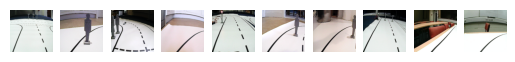

In [ ]:
f, axarr = plt.subplots(1,10)

i = 0
for image_batch, label_batch in dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 10:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
plt.show()

# 2) Model Building - MobileNetV3Large Transfer Learning

a) Set up model architecture

b) define training step

c) training the model on the training set

d) fine-tuning

### 2a) Set up model architecture

- MobileNetV2 to learn lower level features
- global average pooling layer
- drop out layer
- dense layer with sigmoid activation

In [ ]:
dropoutrate = 0.2
num_classes = 1 # we're only predicting the prob of the positive class with a sigmoid
input_shape = (224,224,3)

mbnet = tf.keras.applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    minimalistic=False
)

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

model.build()

mbnet.trainable = False # freeze the first layers to the imagenet weights

model.summary() # print the model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,997,313 (11.43 MB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

### 2b) Define training step

- adam optimiser
- binary cross entropy loss function

In [ ]:
LR = 0.001  # learning rate
optimizer = tf.optimizers.Adam(LR)

@tf.function
def train_step(model, X, Y):
    with tf.GradientTape() as tape:
        pred = model(X)  # Get the predictions from the model

        # Use binary cross-entropy for binary classification
        current_loss = tf.reduce_mean(tf.losses.binary_crossentropy(Y, pred))

    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Threshold predictions to binary values (0 or 1) for accuracy calculation
    pred_binary = tf.cast(pred > 0.5, dtype=tf.int32)  # Convert predictions to binary (0 or 1)

    # Calculate True Positives, False Positives, True Negatives, False Negatives
    TP = tf.reduce_sum(tf.cast((pred_binary == 1) & (Y == 1), dtype=tf.int32))
    TN = tf.reduce_sum(tf.cast((pred_binary == 0) & (Y == 0), dtype=tf.int32))
    FP = tf.reduce_sum(tf.cast((pred_binary == 1) & (Y == 0), dtype=tf.int32))
    FN = tf.reduce_sum(tf.cast((pred_binary == 0) & (Y == 1), dtype=tf.int32))

    # Calculate Balanced Accuracy
    sensitivity = TP / (TP + FN)  # Recall for class 1
    specificity = TN / (TN + FP)  # Recall for class 0
    balanced_accuracy = 0.5 * (sensitivity + specificity)

    return current_loss, balanced_accuracy


### 2c) Training the model on the training set

In [ ]:
niter = 50

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    # Training
    batch_losses = []
    batch_accs = []
    for image_batch, label_batch in train_dataset:
        # Convert labels to correct format for binary classification
        # Convert to [batch_size, 1] for binary classification with sigmoid
        labels = tf.expand_dims(tf.cast(label_batch, dtype=tf.float32), axis=1)
        loss, acc = train_step(model, image_batch, labels)
        batch_losses.append(loss)
        batch_accs.append(acc)

    # Average metrics for this epoch
    avg_loss = tf.reduce_mean(batch_losses).numpy()
    avg_acc = tf.reduce_mean(batch_accs).numpy()
    tloss.append(avg_loss)
    tacc.append(avg_acc)

    # LOGGING METRICS TO CHECK HOW TRAIING IS GOING

    if it % 10 == 0:
        tf.print(f'iter: {it}, train_loss: {avg_loss:.3f}, train_balanced_acc: {avg_acc:.3f}')

        # If you have a validation dataset, evaluate on it
        if 'val_dataset' in globals():
            val_losses = []
            val_accs = []
            for val_images, val_labels in val_dataset:
                val_labels = tf.expand_dims(tf.cast(val_labels, dtype=tf.float32), axis=1)
                val_preds = model(val_images)
                val_loss = tf.reduce_mean(tf.losses.binary_crossentropy(val_labels, val_preds))

                # Use the same balanced accuracy calculation as in train_step
                pred_binary = tf.cast(val_preds > 0.5, dtype=tf.int32)
                val_labels_int = tf.cast(val_labels, dtype=tf.int32)

                TP = tf.reduce_sum(tf.cast((pred_binary == 1) & (val_labels_int == 1), dtype=tf.int32))
                TN = tf.reduce_sum(tf.cast((pred_binary == 0) & (val_labels_int == 0), dtype=tf.int32))
                FP = tf.reduce_sum(tf.cast((pred_binary == 1) & (val_labels_int == 0), dtype=tf.int32))
                FN = tf.reduce_sum(tf.cast((pred_binary == 0) & (val_labels_int == 1), dtype=tf.int32))

                sensitivity = TP / (TP + FN + 1e-7)
                specificity = TN / (TN + FP + 1e-7)
                val_acc = 0.5 * (sensitivity + specificity)

                val_losses.append(val_loss)
                val_accs.append(val_acc)

            avg_val_loss = tf.reduce_mean(val_losses).numpy()
            avg_val_acc = tf.reduce_mean(val_accs).numpy()
            vloss.append(avg_val_loss)
            vacc.append(avg_val_acc)

            tf.print(f'val_loss: {avg_val_loss:.3f}, val_balanced_acc: {avg_val_acc:.3f}')

2025-03-12 16:59:49.871060: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
W0000 00:00:1741798789.966706 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741798790.038072 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741798790.038871 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741798790.039512 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741798790.047576 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741798790.050394 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741798790.051118 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741798790.051872 3170077 gpu_

iter: 0, train_loss: 0.470, train_balanced_acc: 0.546


2025-03-12 17:02:05.244966: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


iter: 10, train_loss: 0.232, train_balanced_acc: 0.845


2025-03-12 17:05:39.845966: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


iter: 20, train_loss: 0.194, train_balanced_acc: 0.872


2025-03-12 17:12:44.691065: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


iter: 30, train_loss: 0.178, train_balanced_acc: 0.883
iter: 40, train_loss: 0.169, train_balanced_acc: 0.888


In [ ]:
model.save_weights('/home/apyba3/car_frozen_regression_mobv3.weights.h5')
# model.save_weights('/home/ppytr13/car_frozen.weights.h5')

In [ ]:
tf.keras.backend.clear_session() #Clear keras session

### 2d) fine-tuning

rebuild model after clearing keras session

In [ ]:
dropoutrate = 0.2
num_classes = 1 # we're only predicting the prob of the positive class with a sigmoid
input_shape = (224,224,3)

mbnet = tf.keras.applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    minimalistic=False
)

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])
model.build()

mbnet.trainable = True # UNFREEZE the first layers to the imagenet weights

model.summary() # print the model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,997,313 (11.43 MB)

 Trainable params: 2,972,913 (11.34 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [ ]:
model.load_weights('/home/apyba3/car_frozen_regression_mobv3.weights.h5')
# model.load_weights('/home/ppytr13/car_frozen.weights.h5')

Set up fine-tuning training

In [ ]:
LR = 0.0001
optimizer = tf.optimizers.Adam(LR) #adam optimiser

In [ ]:
@tf.function
def train_step(model, X, Y):
    with tf.GradientTape() as tape:
        pred = model(X)  # Get the predictions from the model

        # Use binary cross-entropy for binary classification
        current_loss = tf.reduce_mean(tf.losses.binary_crossentropy(Y, pred))

    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Threshold predictions to binary values (0 or 1) for accuracy calculation
    pred_binary = tf.cast(pred > 0.5, dtype=tf.int32)  # Convert predictions to binary (0 or 1)

    # Calculate True Positives, False Positives, True Negatives, False Negatives
    TP = tf.reduce_sum(tf.cast((pred_binary == 1) & (Y == 1), dtype=tf.int32))
    TN = tf.reduce_sum(tf.cast((pred_binary == 0) & (Y == 0), dtype=tf.int32))
    FP = tf.reduce_sum(tf.cast((pred_binary == 1) & (Y == 0), dtype=tf.int32))
    FN = tf.reduce_sum(tf.cast((pred_binary == 0) & (Y == 1), dtype=tf.int32))

    # Calculate Balanced Accuracy
    sensitivity = TP / (TP + FN)  # Recall for class 1
    specificity = TN / (TN + FP)  # Recall for class 0
    balanced_accuracy = 0.5 * (sensitivity + specificity)

    return current_loss, balanced_accuracy

In [ ]:
niter = 50

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    # Training
    batch_losses = []
    batch_accs = []
    for image_batch, label_batch in train_dataset:
        # Convert labels to correct format for binary classification
        # Convert to [batch_size, 1] for binary classification with sigmoid
        labels = tf.expand_dims(tf.cast(label_batch, dtype=tf.float32), axis=1)
        loss, acc = train_step(model, image_batch, labels)
        batch_losses.append(loss)
        batch_accs.append(acc)

    # Average metrics for this epoch
    avg_loss = tf.reduce_mean(batch_losses).numpy()
    avg_acc = tf.reduce_mean(batch_accs).numpy()
    tloss.append(avg_loss)
    tacc.append(avg_acc)

    # LOGGING METRICS TO CHECK HOW TRAIING IS GOING

    if it % 10 == 0:
        tf.print(f'iter: {it}, train_loss: {avg_loss:.3f}, train_balanced_acc: {avg_acc:.3f}')

        # If you have a validation dataset, evaluate on it
        if 'val_dataset' in globals():
            val_losses = []
            val_accs = []
            for val_images, val_labels in val_dataset:
                val_labels = tf.expand_dims(tf.cast(val_labels, dtype=tf.float32), axis=1)
                val_preds = model(val_images)
                val_loss = tf.reduce_mean(tf.losses.binary_crossentropy(val_labels, val_preds))

                # Use the same balanced accuracy calculation as in train_step
                pred_binary = tf.cast(val_preds > 0.5, dtype=tf.int32)
                val_labels_int = tf.cast(val_labels, dtype=tf.int32)

                TP = tf.reduce_sum(tf.cast((pred_binary == 1) & (val_labels_int == 1), dtype=tf.int32))
                TN = tf.reduce_sum(tf.cast((pred_binary == 0) & (val_labels_int == 0), dtype=tf.int32))
                FP = tf.reduce_sum(tf.cast((pred_binary == 1) & (val_labels_int == 0), dtype=tf.int32))
                FN = tf.reduce_sum(tf.cast((pred_binary == 0) & (val_labels_int == 1), dtype=tf.int32))

                sensitivity = TP / (TP + FN + 1e-7)
                specificity = TN / (TN + FP + 1e-7)
                val_acc = 0.5 * (sensitivity + specificity)

                val_losses.append(val_loss)
                val_accs.append(val_acc)

            avg_val_loss = tf.reduce_mean(val_losses).numpy()
            avg_val_acc = tf.reduce_mean(val_accs).numpy()
            vloss.append(avg_val_loss)
            vacc.append(avg_val_acc)

            tf.print(f'val_loss: {avg_val_loss:.3f}, val_balanced_acc: {avg_val_acc:.3f}')

W0000 00:00:1741800775.263420 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741800775.268896 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741800775.269576 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741800775.270204 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741800775.296474 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741800775.297412 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741800775.298268 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741800775.299129 3170077 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1741800775.338158 3170077 gp

iter: 0, train_loss: 0.150, train_balanced_acc: 0.917
iter: 10, train_loss: 0.022, train_balanced_acc: 0.989


2025-03-12 17:44:24.706662: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


iter: 20, train_loss: 0.012, train_balanced_acc: 0.994
iter: 30, train_loss: 0.009, train_balanced_acc: 0.996
iter: 40, train_loss: 0.003, train_balanced_acc: 0.998


In [ ]:
model.save_weights('car_unfrozen_regression_mobv3.weights.h5')
# model.save_weights('/home/ppytr13/car_unfrozen.weights.h5')

# 3) Test-Set Predictions

a) load in test data

b) convert test images to numerical RGB feature maps

c) generate predictions on the test set

d) correctly format the predictions into a pandas dataframe

e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

### 3a) load in test data

In [ ]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data'
# image_folder_path = '/home/ppyt13/machine-learning-in-science-ii-2025/test_data/test_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/5.png


### 3b) convert test images to numerical RGB feature maps

In [ ]:
def process_image_no_label(image_path, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_png for PNG images
    image = tf.image.resize(image, resized_shape)  # Resize to uniform shape
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image

test_dataset = tf.data.Dataset.from_tensor_slices((imagefilepaths_df["image_file_paths"]))

test_dataset = test_dataset.map(process_image_no_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### 3c) generate predictions on test set

In [ ]:
predictions = model.predict(test_dataset)

I0000 00:00:1741803949.791641 3170072 service.cc:146] XLA service 0x7f4e8c069d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741803949.791767 3170072 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1741803949.791776 3170072 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-03-12 18:25:50.146153: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3:13 6s/step

I0000 00:00:1741803954.880201 3170072 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step


### 3d) correctly format the predictions into a pandas dataframe

In [ ]:
predictions_df = pd.DataFrame(predictions, columns=['speed'])

In [ ]:
predictions_df.head()

,speed
0,1.222957e-37
1,1.000000e+00
2,9.996747e-01
3,9.997604e-01
4,9.999691e-01


sigmoid output is between [0,1]

In [ ]:
predictions_df[predictions_df['speed'] > 0.5] = 1
predictions_df[predictions_df['speed'] < 0.5] = 0

kaggle expects integers for the speed column

In [ ]:
predictions_df['speed'] = predictions_df['speed'].astype(int)

In [ ]:
predictions_df.head()

,speed
0,0
1,1
2,1
3,1
4,1


In [ ]:
predictions_df['speed'].value_counts()

speed
1    513
0    507
Name: count, dtype: int64

### 3e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

In [ ]:
predictions_df.to_csv('/home/apyba3/mbnetv3_speedclassification_predictions.csv')